# Basic analysis and optimization
Francis Deck, 11-26-2022

I just want to try *something* that will test the ability of my program to optimize.

It's a success. So, what's the problem? Why doesn't this replace one of the commercial packages? The reason is that those packages provide an *extreme* number of merit function operands, whereas you have to write each one yourself here.

In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import import_ipynb
import raytrace as rt
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This is a modified version of the same function from the **raytrace** notebook, but with an added feature of returning a table of field numbers, so I can separate the fields later on during analysis.

In [11]:
def ray_table_from_fields_points(geometry, field_points, pupil_points):
    ray_table = np.empty(
        [len(geometry), len(field_points)*len(pupil_points), 2, 3])
    field_nums = np.empty([len(field_points)*len(pupil_points)])
    for i in range(len(field_points)):
        for j in range(len(pupil_points)):
            k = j + i*len(pupil_points)
            ray_table[0, k, 0, :] = field_points[i]
            ray_table[0, k, 1, :] = rt.normalize(
                pupil_points[j] - field_points[i])
            field_nums[k] = i
    return ray_table, {'field_num': field_nums}

Let's define a basic starting point, a doublet of lenses with finite conjugates, and a bunch of randomly generated rays. The ray list will stay the same during analysis, only the design will change.

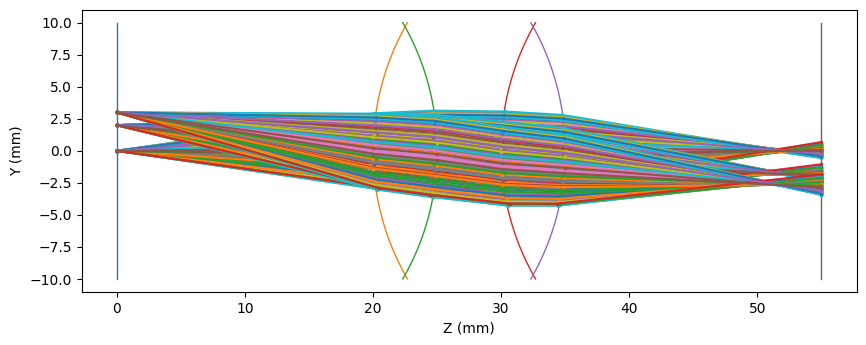

In [12]:
start_r = 20

surface_list = [
    {'surf': 'dummy', 'dist': 20, 'draw_radius': 10},
    {'surf': 'conic', 'c': 1/start_r, 'k': 0, 'n1': 1, 'n2': 1.5, 'dist': 5, 'draw_radius': 10},
    {'surf': 'conic', 'c': -1/start_r, 'k': 0, 'n1': 1.5, 'n2': 1, 'dist': 5, 'draw_radius': 10},
    {'surf': 'conic', 'c': 1/start_r, 'k': 0, 'n1': 1, 'n2': 1.5, 'dist': 5, 'draw_radius': 10},
    {'surf': 'conic', 'c': -1/start_r, 'k': 0, 'n1': 1.5, 'n2': 1, 'dist': 20, 'draw_radius': 10},
    {'surf': 'dummy', 'dist': 20, 'draw_radius': 10}
]

geometry = rt.build_geometry(surface_list)

field_vals = np.array([0, 2, 3])
field_points = np.array([np.array([0, y, 0]) for y in field_vals])
pupil_points = np.empty((100, 3))
pupil_points[:, 0] = np.random.random((100))*6 - 3
pupil_points[:, 1] = np.random.random((100))*6 - 3
pupil_points[:, 2] = np.ones_like(pupil_points[:, 2])*20

ray_table, props = ray_table_from_fields_points(geometry, field_points, pupil_points)

ray_properties = rt.default_ray_properties(ray_table) | props
rt.propagate_ray(ray_table, ray_properties, geometry)
axd = rt.new_plot_xy(['y'], figsize = (10, 10))
rt.plot_faces(axd, geometry)
rt.plot_rays(axd, geometry, ray_table, ray_properties, marker = '.', markersize = 3)

Now for a really crude analysis feature. First, a function that returns a list of points on one of the surfaces in the design. We'll probably use this over and over, hopefully improving it.

0 0.2949016362644014
1 0.34268982357172456
2 0.3998004237402199


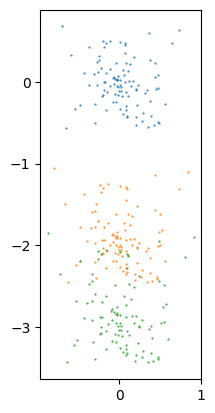

In [13]:
def points_on_surface(ray_table, ray_properties, geometry, i, fn):
    surf = geometry[i]
    keep = ray_properties['field_num'] == fn
    x = np.sum(ray_table[i, keep, 0, :]*surf['x_axis'][np.newaxis, :], axis = 1)
    y = np.sum(ray_table[i, keep, 0, :]*surf['y_axis'][np.newaxis, :], axis = 1)
    return x, y

last = len(geometry) - 1
for i in range(3):
    xa, ya = points_on_surface(ray_table, ray_properties, geometry, -1, i)
    plt.plot(xa, ya, ls = 'none', marker = '.', markersize = 1)
    print(i, np.std(ya))
plt.gca().set_aspect("equal")

Now a crude merit function, just the RMS Y of each field. The merit function has to rebuild the geometry each time because its parameters are changing. But it shouldn't rebuild the ray table. The reason is that the ray table has to stay constant. Randomizing the rays at each iteration makes the merit function non-differentiable, and the minimization process less robust.

The graphing functions are in there, so the graphs can reflect the same design as what the optimize function spits out.

In [14]:
def merit_function(r, draw1 = False, draw2 = False):
    surface_list = [
        {'surf': 'dummy', 'dist': 20, 'draw_radius': 10},
        {'surf': 'conic', 'c': 1/r[0], 'k': 0, 'n1': 1, 'n2': 1.5, 'dist': 5, 'draw_radius': 10},
        {'surf': 'conic', 'c': -1/r[1], 'k': 0, 'n1': 1.5, 'n2': 1, 'dist': 5, 'draw_radius': 10},
        {'surf': 'conic', 'c': 1/r[2], 'k': 0, 'n1': 1, 'n2': 1.5, 'dist': 5, 'draw_radius': 10},
        {'surf': 'conic', 'c': -1/r[3], 'k': 0, 'n1': 1.5, 'n2': 1, 'dist': 20, 'draw_radius': 10},
        {'surf': 'dummy', 'dist': 20, 'draw_radius': 10}
    ]
    geometry = rt.build_geometry(surface_list)
    rt.propagate_ray(ray_table, ray_properties, geometry)
    merit = 0
    for i in range(3):
        xa, ya = points_on_surface(ray_table, ray_properties, geometry, -1, i)
        if draw2:
            plt.plot(xa, ya, marker = '.', markersize = 1, linestyle = 'none')
        merit = merit + np.std(ya)**2
    if draw1:
        axd = rt.new_plot_xy(['y'], figsize = (10, 10))
        rt.plot_faces(axd, geometry)
        rt.plot_rays(axd, geometry, ray_table, ray_properties)
        
    return merit
    
merit_function([20, 20, 20, 20])

0.36424366907390043

Finally I'm just going to throw the **scipy.optimize.minimize()** function at it with no options!

In [15]:
m = minimize(merit_function, [22, 22, 22, 22])
m

      fun: 0.0087166332367976
 hess_inv: array([[ 3.40185593e+06, -5.07361479e+04, -1.01782423e+05,
         5.76990429e+04],
       [-5.07361479e+04,  1.29965986e+03,  9.12736311e+02,
        -3.59075483e+03],
       [-1.01782423e+05,  9.12736311e+02,  1.35780512e+04,
        -2.76186938e+04],
       [ 5.76990429e+04, -3.59075483e+03, -2.76186938e+04,
         1.00071581e+05]])
      jac: array([-1.18743628e-08, -3.04775313e-07, -1.12573616e-07, -1.85100362e-08])
  message: 'Optimization terminated successfully.'
     nfev: 670
      nit: 112
     njev: 134
   status: 0
  success: True
        x: array([70.99448572, 12.43037014, 20.12641347, 31.53957793])

These are the "after" pictures.

0.0087166332367976

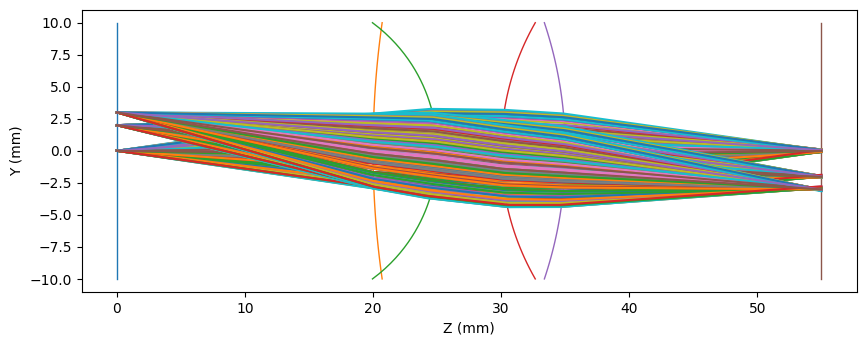

In [16]:
merit_function(m.x, draw1 = True)

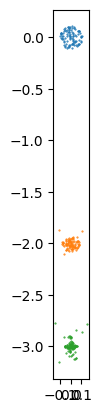

In [17]:
merit_function(m.x, draw2 = True)
plt.gca().set_aspect("equal")